In [1]:
import matplotlib.pyplot as plt
from deep_learning_at_scale.chapter_4.dataset import (
    SceneParsingModule,
    SceneParsingDataset,
)
import kornia as K

/home/coder/wks/deep_learning_at_scale/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
loader = SceneParsingModule(
    batch_size=4,
    input_size=256,
    num_workers=2,
)
loader.setup("fit")
for images, _ in loader.train_dataloader():
    break

/home/coder/wks/deep_learning_at_scale/.venv/lib/python3.9/site-packages/datasets/load.py:1491: FutureWarning: The repository for scene_parse_150 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/scene_parse_150
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 9235.78 examples/s]
/home/coder/wks/deep_learning_at_scale/.venv/lib/python3.9/site-packages/datasets/load.py:1491: FutureWarning: The repository for scene_parse_150 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/scene_parse_150
You can avoid this message in future by passing the argument `trust_remote_code=True`.


In [3]:
transforms = K.augmentation.ImageSequential(
    K.augmentation.RandomHorizontalFlip(p=0.5),  # Geometric augmentation
    K.augmentation.RandomVerticalFlip(p=0.5),  # Geometric augmentation
    K.augmentation.RandomBoxBlur(),  # Region based pixel blur
    K.augmentation.RandomGaussianBlur(
        kernel_size=(3, 3), sigma=(0.1, 2.0), p=0.5
    ),  # Random noise and blur introduction
    K.augmentation.ColorJitter(
        0.1, 0.1, 0.1, 0.1, p=0.5
    ),  # Pixel intensity augmentation
    K.augmentation.RandomSharpness(p=0.5),  # Pixel intensity augmentation
    K.augmentation.RandomThinPlateSpline(p=0.5),  # Geometric deformation augmentation
    K.augmentation.RandomSnow(p=0.5),  # Feature Introduction augmentation
    K.augmentation.RandomErasing(p=0.1),  # Geometric augmentation
)

In [4]:
t1 = transforms(images).permute(0, 2, 3, 1).numpy()
t2 = transforms(images).permute(0, 2, 3, 1).numpy()
t3 = transforms(images).permute(0, 2, 3, 1).numpy()
t4 = transforms(images).permute(0, 2, 3, 1).numpy()
images_np = images.permute(0, 2, 3, 1).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.012381228..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06199547..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06532668..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.010316104..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.012183928..1.000000

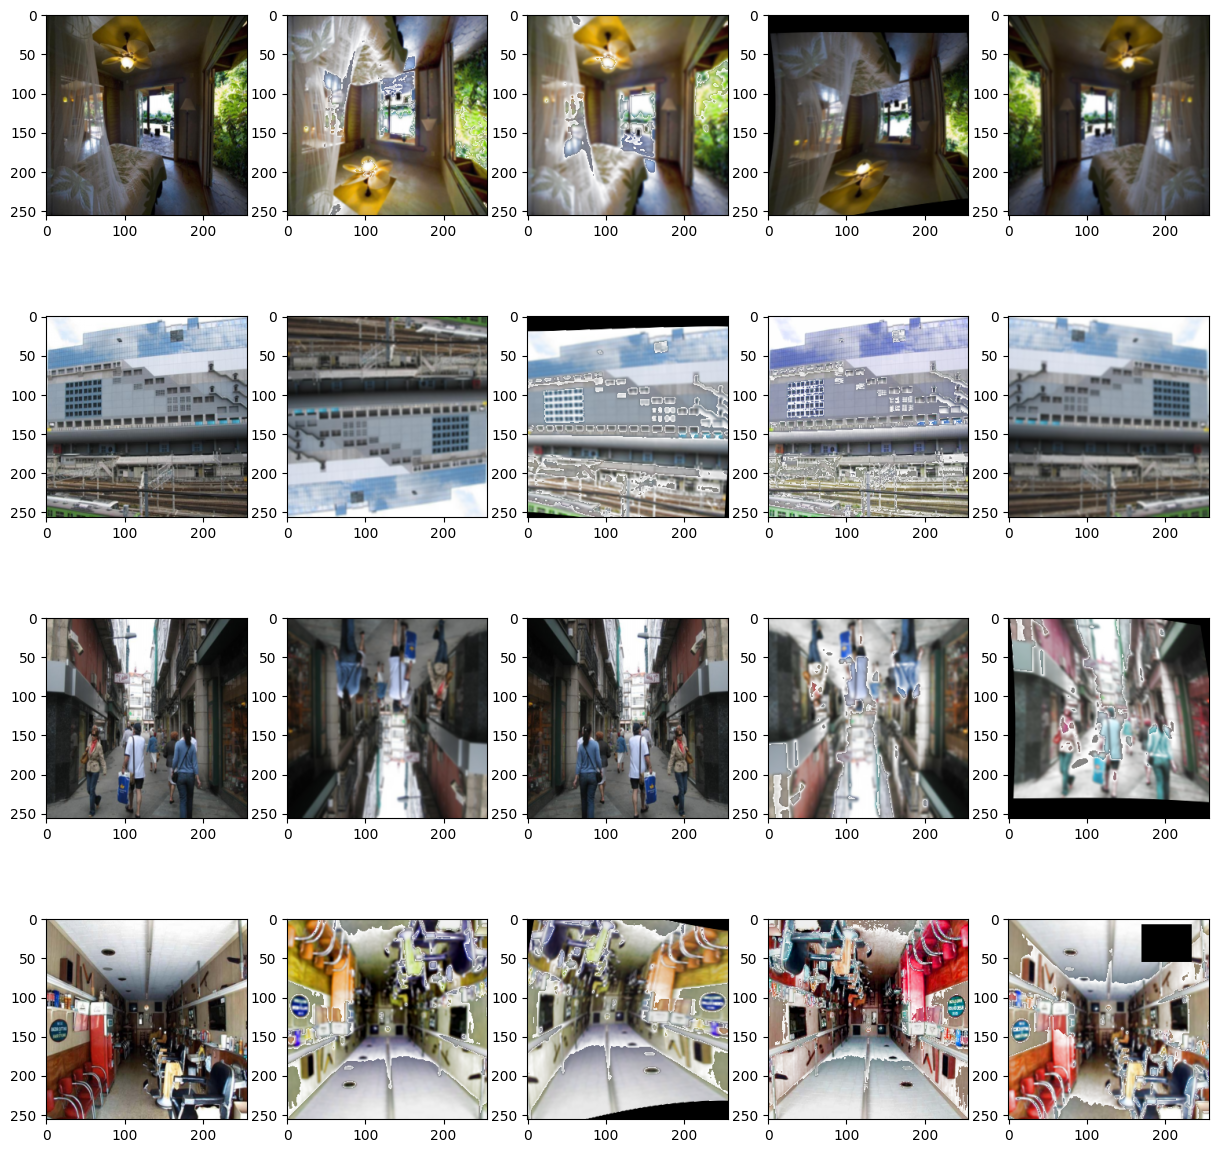

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15))
for i in range(4):
    axes[i, 0].imshow(images_np[i])
    axes[i, 1].imshow(t1[i])
    axes[i, 2].imshow(t2[i])
    axes[i, 3].imshow(t3[i])
    axes[i, 4].imshow(t4[i])

## MixUp Augmentation

In [6]:
import numpy as np
import torch
from typing import Tuple


def mixup(
    input: torch.Tensor,
    target: torch.Tensor,
    gamma: float,
) -> Tuple[torch.Tensor, torch.Tensor]:
    def _mix(input: torch.Tensor, gamma: float, indices: torch.Tensor) -> torch.Tensor:
        return input.mul(gamma).add(input[indices], alpha=1 - gamma)

    permutated_indices = torch.randperm(
        input.size(0), device=input.device, dtype=torch.long
    )
    return _mix(input, gamma, permutated_indices), _mix(
        target, gamma, permutated_indices
    )


for images, labels in loader.train_dataloader():
    hot_label = torch.nn.functional.one_hot(labels.long(), num_classes=150)
    hot_label = hot_label.float()
    input, target = mixup(images, hot_label, np.random.beta(2.0, 2.0))
    # obtain 2D mixup labels
    target = (target * torch.tensor(range(1, 151), device=hot_label.device)[None, None, None, :])
    target = target.sum(dim=-1)
    break

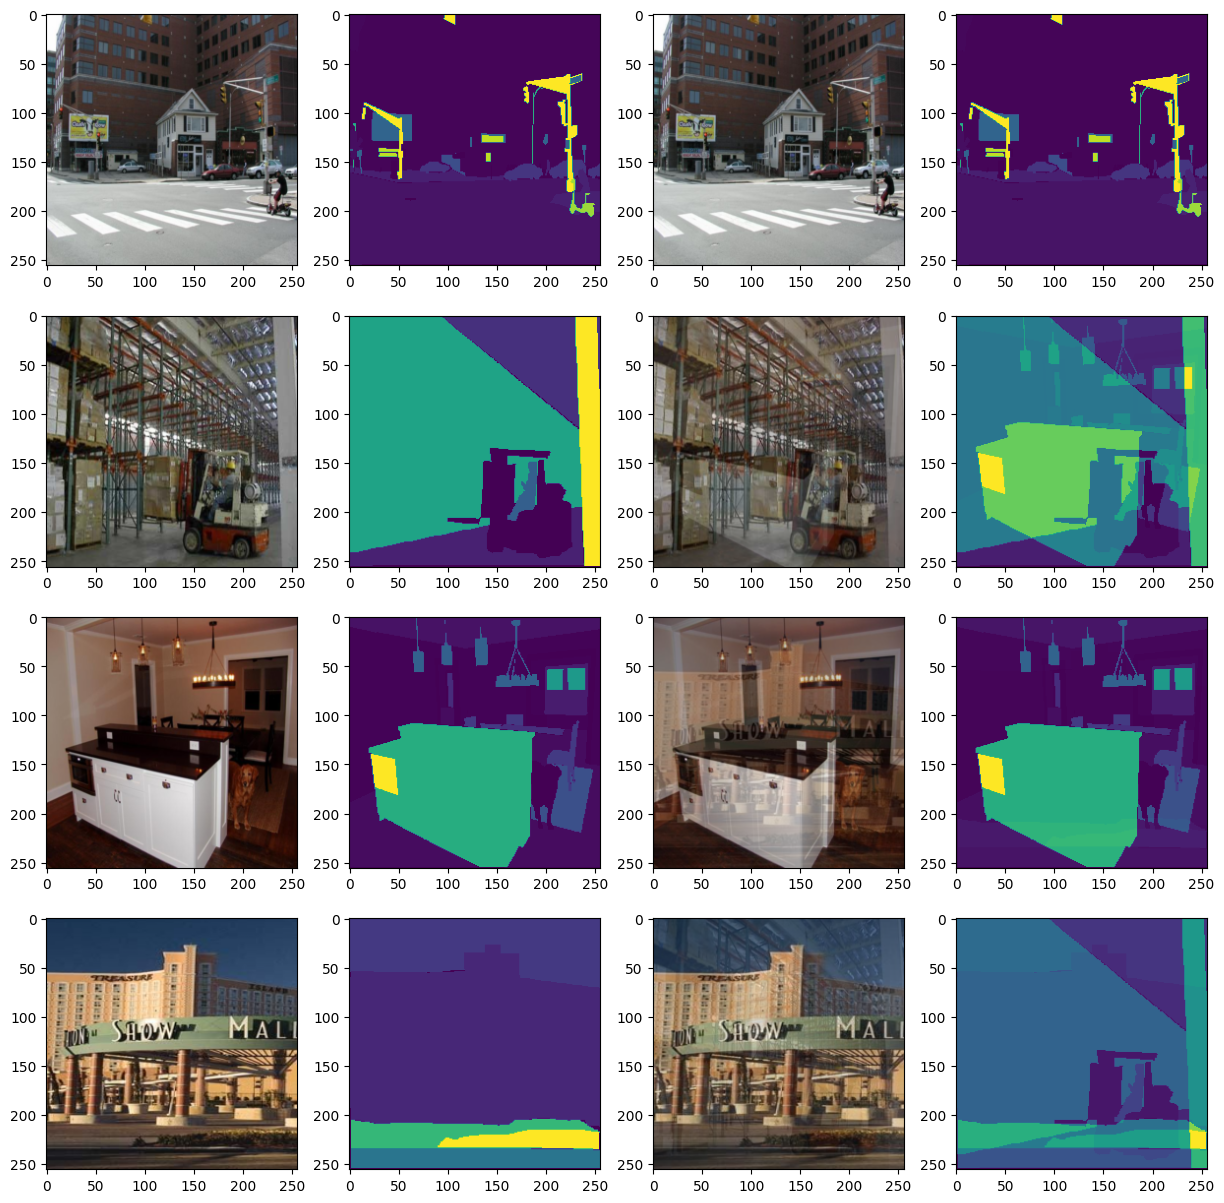

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for i in range(4):
    axes[i, 0].imshow(images[i].permute(1, 2, 0).numpy())
    axes[i, 1].imshow(labels[i].numpy())
    axes[i, 2].imshow(input[i].permute(1, 2, 0).numpy())
    axes[i, 3].imshow(target[i].numpy())